# Hierarchical inference of cosmology and galaxy density profile from TDCOSMO+SLACS

This notebook reads in the processed individual lensing likelihood products and then performs the hierarchical inference of the joint data products. The notebook allows to select a specific (sub-)set of the data, choice of prior and hierarchical parameterization.

Note, that the sampling may take significant runtime to fully convergen.

Author: Simon Birrer

In [1]:
# some standard python imports #
import copy
import numpy as np
import corner
import emcee
import pickle
import os
import csv
from os.path import dirname, abspath
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

np.random.seed(seed=10)

from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

from hierarc.Sampling.mcmc_sampling import MCMCSampler
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Diagnostics.goodness_of_fit import GoodnessOfFit
from lenstronomy.Plots import plot_util


path2Analysis = dirname(abspath(os.getcwd()))

path2tdcosmo = 'TDCOSMO_sample'
path2slacs = 'SLACS_sample'
path2kappa = os.path.join(path2Analysis, path2slacs, 'kappaSLACS')

file_name_tdcosmo = os.path.join(path2Analysis, path2tdcosmo, 'tdcosmo_sample.csv')
file_name_slacs = os.path.join(path2Analysis, path2slacs, 'slacs_all_params.csv')
file_name_slacs_los = os.path.join(path2Analysis, path2slacs, 'LineOfSightData.csv')


In [17]:

anisotropy_model = 'OM' # 'OM', 'GOM' or 'const'
anisotropy_distribution = 'GAUSSIAN'  # 'NONE' or 'GAUSSIAN'

blinded_plot = False  # shows plots blinded in regard of H_0 and lambda_int

all_slacs_sample = True  # bool, if True, uses all SLACS lenses, also those without individual lensing-only power-law slope measurements and applies to those the population distribution prior

num_distribution_draw = 200  # number of draws from the hyper parameter distribution in computing the Monte Carlo integral marginalization
ifu_mst_sampling_separate = True  # if True, samples a separate MST parameter for the IFU lenses
sigma_v_systematics = True  # bool, if True, samples an additional uncorrelated Gaussian uncertainty on all the velocity dispersion measurements of the SDSS data

lambda_slope = True  # allow for linear scaling of lambda_int with r_eff/theta_E
omega_m_prior = True  # if True, sets a flat prior
log_scatter = True  # scatter parameters sampled in log space with linear prior in log space 

run_chains = True  # boolean, if True, runs the chains, else uses the stored chains to do the plotting 
continue_from_backend = True  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch 

n_walkers = 100
n_run = 100
n_burn = 0



if anisotropy_model == 'OM':
    ifu_sample_file_name = 'slacs_ifu_om_processed.pkl'
    sdss_sample_file_name = 'slacs_slit_om_processed.pkl'
elif anisotropy_model == 'GOM':
    ifu_sample_file_name = 'slacs_ifu_gom_processed.pkl'
    sdss_sample_file_name = 'slacs_ifu_gom_processed.pkl'
    

TDCOSMO_lenses = ['B1608+656', 'RXJ1131-1231', 'HE0435-1223', 'SDSS1206+4332', 'WFI2033-4723', 'PG1115+080', 'DES0408-5354']


    
# import the SLACS sample

# selected slit lenses
# all SLACS lenses with power-law slopes measured from the quality sample of Shajib et al. 2020 passing our selection criteria (see sample_selection notebook) (excluding the lenses with additonal IFU data)
sdss_names_quality = ['SDSSJ1402+6321', 'SDSSJ1630+4520', 'SDSSJ0330-0020', 'SDSSJ0029-0055', 
                      'SDSSJ0728+3835', 'SDSSJ1112+0826', 'SDSSJ1306+0600', 'SDSSJ1531-0105', 
                      'SDSSJ1621+3931']
# all SLACS lenses including those with population prior from Shajib et al. 2020 passing our selection criteria (see sample_selection notebook) (excluding the lenses with additonal IFU data)
sdss_names_all = ['SDSSJ1402+6321', 'SDSSJ1630+4520', 'SDSSJ0330-0020', 'SDSSJ0029-0055', 
                  'SDSSJ0728+3835', 'SDSSJ1112+0826', 'SDSSJ1306+0600', 'SDSSJ1531-0105', 
                  'SDSSJ1621+3931', 'SDSSJ1153+4612', 'SDSSJ0008-0004', 'SDSSJ0044+0113', 
                  'SDSSJ0959+4416', 'SDSSJ1016+3859', 'SDSSJ1020+1122', 'SDSSJ1134+6027', 
                  'SDSSJ1142+1001', 'SDSSJ1213+6708', 'SDSSJ1218+0830', 'SDSSJ1432+6317', 
                  'SDSSJ1644+2625', 'SDSSJ2347-0005', 'SDSSJ1023+4230', 'SDSSJ1403+0006']


# selected IFU lenses within the criteria
ifu_names_quality = ['SDSSJ1627-0053', 'SDSSJ2303+1422', 'SDSSJ1250+0523', 'SDSSJ1204+0358', 'SDSSJ0037-0942']
# all including population prior
ifu_names_all = ['SDSSJ1627-0053', 'SDSSJ2303+1422', 'SDSSJ1250+0523', 'SDSSJ1204+0358', 'SDSSJ0037-0942', 'SDSSJ0912+0029', 'SDSSJ2321-0939', 'SDSSJ0216-0813', 'SDSSJ1451-0239']



# here we add the IFU lenses to the sdss sample. We don't double count unless we allow the IFU data to constrain the MST

#if ifu_mst_sampling_separate is True:
sdss_names_quality += ifu_names_quality
sdss_names_all += ifu_names_all

# this is for saving the chains under different names
if ifu_mst_sampling_separate is True:
    model_prefix = 'ifu_separate'    
else:
    model_prefix = 'ifu_joint'
if lambda_slope is True:
    lambda_prefix = '_slope'
else:
    lambda_prefix = ''
    
if omega_m_prior is False:
    lambda_prefix += '_flat_om'
if log_scatter is True:
    lambda_prefix += '_log_scatter'

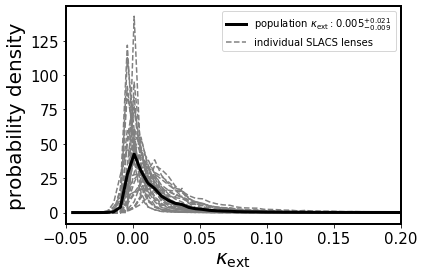

In [3]:
from hierarc.Util.distribution_util import PDFSampling

names_selected = sdss_names_all

percentiles = [16, 50, 84]
quantiles = [0.16, 0.5, 0.84]
title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
fmt = "{{0:{0}}}".format(".3f").format

# option with file ending
with_shear = False  # bool, if True, adds shear constraints in LOS estimate (only available for a subset of the sample)

kappa_choice_shear_ending = '_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_gamma_120_oneoverr_23.0_med_increments2_16_2_emptymsk_shearwithoutprior.cat'
kappa_choice_no_shear_ending = '_computed_1innermask_nobeta_zgap-1.0_-1.0_fiducial_120_gal_120_oneoverr_23.0_med_increments2_2_emptymsk.cat'


if with_shear is True:
    kappa_choice_ending = kappa_choice_shear_ending
else:
    kappa_choice_ending = kappa_choice_no_shear_ending
    
    
kappa_bins = np.linspace(-0.05, 0.2, 50)


# loop through selected lenses

kappa_pdf_tot = np.zeros(len(kappa_bins)-1)
num_lenses = 0

for name in names_selected:
    filepath = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_ending)
 
    try:
        output = np.loadtxt(filepath, delimiter=' ', skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True) #, bins=kappa_bins
        kappa_pdf_tot += kappa_pdf
        plt.plot(kappa_bin_edges[1:], kappa_pdf, '--', color='gray')  # which do not include systematics and covariances 
        num_lenses += 1

    except:
        print('lens %s does not have a file %s' % (name, filepath))

kappa_pdf_tot /= num_lenses
kappa_bin_edges_tot = kappa_bin_edges

pdf_tot = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf_tot/num_lenses)
kappa_samples_tot = pdf_tot.draw(n=100000)
pcs = np.percentile(kappa_samples_tot, q=percentiles)
txt = r'$\kappa_{\rm ext}: $' + title.format(fmt(pcs[1]), fmt(pcs[1] - pcs[0]), fmt(pcs[2] - pcs[1]))
plt.plot(kappa_bin_edges[1:], kappa_pdf_tot, '-k', linewidth=3, label='population ' + txt)        
        
plt.plot(-1, -1,  '--', color='gray', label=r'individual SLACS lenses')
plt.xlim([-0.05, 0.2])
plt.xlabel(r"$\kappa_{\rm ext}$", fontsize=20)
plt.ylabel(r"probability density", fontsize=20)
plt.legend()
plt.show()


def read_kappa_pdf(name, kappa_bins):
    filepath = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_ending)
    try:
        output = np.loadtxt(filepath, delimiter=' ', skiprows=1)
        kappa_sample = output[:, 0]
        kappa_weights = output[:, 1]
        kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True)
        return kappa_pdf, kappa_bin_edges
    except:
        print('individual kappa_distribution for %s not available, using the population distribution instead.' %name)
        return kappa_pdf_tot, kappa_bin_edges_tot
            
            
def properties(name, file_name, partial_name=False):
    with open(file_name, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if (partial_name and name[:4] == str(row['name'])[:4]) or name == str(row['name']):
                
            #if name == str(row['name']):
                theta_E = float(row['theta_E'])
                z_lens = float(row['z_lens'])
                z_source = float(row['z_source'])
                r_eff = float(row['r_eff'])
                lensCosmo = LensCosmo(z_lens, z_source, cosmo=None)
                sigma_sis = lensCosmo.sis_theta_E2sigma_v(theta_E)
                try:
                    gamma_pl = float(row['gamma'])
                except:
                    gamma_pl = -1
                return theta_E, r_eff, gamma_pl, z_lens, z_source, sigma_sis


In [4]:
# import TDCOSMO sample
tdcosmo_posterior_list = []
for tdcosmo_lens in TDCOSMO_lenses:
    td_cosmo_file_name = os.path.join(path2Analysis, path2tdcosmo, tdcosmo_lens+'_processed.pkl')
    file = open(td_cosmo_file_name, 'rb')
    posterior = pickle.load(file)
    file.close()
    posterior['num_distribution_draws'] = num_distribution_draw
    posterior['error_cov_measurement'] = np.array(posterior['error_cov_measurement'], dtype='float')
    theta_E, r_eff, gamma_pl, z_lens, z_source, sigma_sis = properties(tdcosmo_lens, file_name_tdcosmo, partial_name=True)
    posterior['lambda_scaling_property'] = r_eff/theta_E - 1
    tdcosmo_posterior_list.append(posterior)



kwargs_ifu_all_list = []
kwargs_ifu_quality_list = []


file = open(os.path.join(path2Analysis, path2slacs, ifu_sample_file_name) , 'rb')
posterior_ifu_list = pickle.load(file)
file.close()
for kwargs_posterior in posterior_ifu_list:
    name = kwargs_posterior['name']
    #if name == 'SDSSJ0216-0813 ':
    #    name  = 'SDSSJ0216-0813'
    if name in ifu_names_all:
        kwargs_posterior_copy = copy.deepcopy(kwargs_posterior)
        if 'flag_ifu' in kwargs_posterior_copy:
            del kwargs_posterior_copy['flag_ifu']
        if 'flag_imaging' in kwargs_posterior_copy:  
            del kwargs_posterior_copy['flag_imaging']
        kwargs_posterior_copy['num_distribution_draws'] = num_distribution_draw
        kappa_pdf, kappa_bin_edges = read_kappa_pdf(name, kappa_bins)
        kwargs_posterior_copy['kappa_pdf'] = kappa_pdf
        kwargs_posterior_copy['kappa_bin_edges'] = kappa_bin_edges
        kwargs_posterior_copy['mst_ifu'] = ifu_mst_sampling_separate
        theta_E, r_eff, gamma_pl, z_lens, z_source, sigma_sis = properties(name, file_name_slacs, partial_name=False)
        kwargs_posterior_copy['lambda_scaling_property'] = r_eff/theta_E - 1
        if not ifu_mst_sampling_separate:  # if we sample the amplitude normalization of the IFU spectra separately, we do not need to include a systematic error on top
            kwargs_posterior_copy['sigma_sys_error_include'] = sigma_v_systematics

        if name in ifu_names_quality:
            kwargs_ifu_quality_list.append(kwargs_posterior_copy)
        if name in ifu_names_all:
            kwargs_ifu_all_list.append(kwargs_posterior_copy)


kwargs_sdss_all_list = []
kwargs_sdss_quality_list = []

file = open(os.path.join(path2Analysis, path2slacs, sdss_sample_file_name) , 'rb')
posterior_sdss_list = pickle.load(file)
file.close()
for kwargs_posterior in posterior_sdss_list:
    name = kwargs_posterior['name']
    if name == 'SDSSJ0216-0813 ':
        name  = 'SDSSJ0216-0813'
    if name in sdss_names_all:
        kwargs_posterior_copy = copy.deepcopy(kwargs_posterior)
        if 'flag_ifu' in kwargs_posterior_copy:
            del kwargs_posterior_copy['flag_ifu']
        if 'flag_imaging' in kwargs_posterior_copy:  
            del kwargs_posterior_copy['flag_imaging']
        kwargs_posterior_copy['num_distribution_draws'] = num_distribution_draw
        kappa_pdf, kappa_bin_edges = read_kappa_pdf(name, kappa_bins)
        kwargs_posterior_copy['kappa_pdf'] = kappa_pdf
        kwargs_posterior_copy['kappa_bin_edges'] = kappa_bin_edges
        kwargs_posterior_copy['sigma_sys_error_include'] = sigma_v_systematics
        theta_E, r_eff, gamma_pl, z_lens, z_source, sigma_sis = properties(name, file_name_slacs, partial_name=False)
        kwargs_posterior_copy['lambda_scaling_property'] = r_eff/theta_E - 1

        if name in sdss_names_quality:
            kwargs_sdss_quality_list.append(kwargs_posterior_copy)
        if name in sdss_names_all:
            kwargs_sdss_all_list.append(kwargs_posterior_copy)
        
if all_slacs_sample is True:
    num_slacs = len(kwargs_sdss_all_list)
    num_ifu = len(kwargs_ifu_all_list)
else:
    num_slacs = len(kwargs_sdss_quality_list)
    num_ifu = len(kwargs_ifu_quality_list)


In [5]:
cosmology = 'FLCDM'  # available models: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'

# there is also the option to sample the post-newtonian parameter gamma_ppn

beta_inf_min, beta_inf_max = 0, 1
a_ani_min, a_ani_max, a_an_mean = 0.1, 5, 1


kwargs_lower_cosmo = {'h0': 0, 'om': 0.05}
kwargs_lower_lens = {'lambda_mst': 0.5, 'lambda_mst_sigma': 0.001, 'kappa_ext': -0.1, 'kappa_ext_sigma': 0., 'lambda_ifu': 0.5, 'lambda_ifu_sigma': 0.01, 'alpha_lambda': -1}
kwargs_lower_kin = {'a_ani': a_ani_min, 'a_ani_sigma': 0.01, 'beta_inf': beta_inf_min, 'beta_inf_sigma': 0.001, 'sigma_v_sys_error': 0.01}

kwargs_upper_cosmo = {'h0': 150, 'om': 0.5}
kwargs_upper_lens = {'lambda_mst': 1.5, 'lambda_mst_sigma': .5, 'kappa_ext': 0.5, 'kappa_ext_sigma': 0.5, 'lambda_ifu': 1.5, 'lambda_ifu_sigma': 0.5, 'alpha_lambda': 1}
kwargs_upper_kin = {'a_ani': a_ani_max, 'a_ani_sigma': 1. ,'beta_inf': beta_inf_max, 'beta_inf_sigma': 1, 'sigma_v_sys_error': 0.5}

# these values are held fixed throughout the entire sampling (optinal to add here)
kwargs_fixed_cosmo = {}
kwargs_fixed_lens = {}

# for the 'GOM' model is beta_inf should be free or fixed=1
kwargs_fixed_kin = {}


kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {'lambda_mst': 1., 'lambda_mst_sigma': .05, 'lambda_ifu': 1, 'lambda_ifu_sigma': 0.05, 'alpha_lambda': 0},
                     'kwargs_kin': {'a_ani': 1, 'a_ani_sigma': 0.1, 'beta_inf': 0.8, 'beta_inf_sigma': 0.1, 'sigma_v_sys_error': 0.05}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.1},
                     'kwargs_lens': {'lambda_mst': .1, 'lambda_mst_sigma': .05, 'lambda_ifu': 0.1, 'lambda_ifu_sigma': 0.05, 'alpha_lambda': 0.1},
                     'kwargs_kin': {'a_ani': 0.3, 'a_ani_sigma': 0.1, 'beta_inf': 0.5, 'beta_inf_sigma': 0.1, 'sigma_v_sys_error': 0.05}}


class CustomPrior(object):
    def __init__(self, om_prior=True, log_scatter=False):
        self._om_prior = om_prior
        self._log_scatter = log_scatter
        self.om_mean = 0.298
        self.sigma_om = 0.022
        
    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin)
    
    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin):

        logL = 0
        # a prior on Omega_m helps in constraining the MST parameter as the kinematics becomes less cosmology dependent...
        if self._om_prior is True:
            om = kwargs_cosmo.get('om', self.om_mean)
            logL += -(om - self.om_mean)**2 / self.sigma_om**2 / 2
        if self._log_scatter is True:
            lambda_mst_sigma = kwargs_lens.get('lambda_mst_sigma', 1)
            logL += np.log(1/lambda_mst_sigma)
            lambda_ifu_sigma = kwargs_lens.get('lambda_ifu_sigma', 1)
            logL += np.log(1/lambda_ifu_sigma)
            a_ani_sigma = kwargs_kin.get('a_ani_sigma', 1)
            logL += np.log(1/a_ani_sigma)
            sigma_v_sys_error = kwargs_kin.get('sigma_v_sys_error', 1)
            logL += np.log(1/sigma_v_sys_error)
            
        a_ani = kwargs_kin.get('a_ani', 1)
        logL += np.log(1/a_ani)
        return logL
    
kwargs_bounds = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                'kwargs_lower_lens': kwargs_lower_lens,
                'kwargs_lower_kin': kwargs_lower_kin,
                'kwargs_upper_cosmo': kwargs_upper_cosmo,
                'kwargs_upper_lens': kwargs_upper_lens,
                'kwargs_upper_kin': kwargs_upper_kin,
                'kwargs_fixed_cosmo': kwargs_fixed_cosmo,
                'kwargs_fixed_lens': kwargs_fixed_lens,
                'kwargs_fixed_kin': kwargs_fixed_kin}

kwargs_sampler = {'lambda_mst_sampling': True,
                 'lambda_mst_distribution': 'GAUSSIAN',
                 'anisotropy_sampling': True,
                 'kappa_ext_sampling': False,  # we do not globally sample a external convergence distribution but instead are using the individually derived p(kappa) products.
                 'kappa_ext_distribution': 'GAUSSIAN',
                 'sigma_v_systematics': sigma_v_systematics,
                 'anisotropy_model': anisotropy_model,
                 'anisotropy_distribution': anisotropy_distribution,
                 'alpha_lambda_sampling': lambda_slope,
                 #'log_scatter': log_scatter,  # you can either sample the parameters in log-space or chose a 1/x prior in the CustomPrior() class. We chose the CustomPrior to specify which parameters have a U(log()) prior.
                 'interpolate_cosmo': True, 'num_redshift_interp': 100,
                 'custom_prior': CustomPrior(om_prior=omega_m_prior, log_scatter=log_scatter)
                 }

# here we sample the tdcosmo data only
kwargs_sampler_tdcosmo = copy.deepcopy(kwargs_sampler)
kwargs_sampler_tdcosmo['sigma_v_systematics'] = False  # we do not add a systematic uncertainty on top of the data products for the TDCOSMO sample and thus do not need to sample this parameter.



## TDCOSMO-only analysis
Here we have the option to sample the TDCOSMO-only analysis, we do not repeat this part as we have sampled it in the TDCOSMO-only notebook.


In [6]:
# first with the tight prior on Omega_m

# we don't need this to do in this notebook as we have a dedicated notebook for the TDCOSMO-only analysis
mcmc_sampler_tdcosmo = MCMCSampler(tdcosmo_posterior_list, cosmology, kwargs_bounds, **kwargs_sampler_tdcosmo)
if False:
    
    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = "tdcosmo_chain"+lambda_prefix+".h5"
    backend = emcee.backends.HDFBackend(filename)
    if run_chains is True:
        mcmc_samples_tdcosmo, log_prob_cosmo = mcmc_sampler_tdcosmo.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                               kwargs_mean_start, kwargs_sigma_start, 
                                                                               continue_from_backend=continue_from_backend, backend=backend)
    else:
        mcmc_samples_tdcosmo = backend.get_chain(discard=n_burn, flat=True, thin=1)
        log_prob_cosmo = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

    corner.corner(mcmc_samples_tdcosmo, show_titles=True, labels=mcmc_sampler_tdcosmo.param_names(latex_style=True))
    plt.show()
else:
    pass  # open chain from other notebook

# and here with a flat prior on Omega_m

# we don't need this to do in this notebook as we have a dedicated notebook for the TDCOSMO-only analysis
if False:
    kwargs_sampler_tdcosmo_flat_omega = copy.deepcopy(kwargs_sampler_tdcosmo)
    kwargs_sampler_tdcosmo_flat_omega['custom_prior'] = CustomPrior(om_prior=False, log_scatter=log_scatter)

    mcmc_sampler_tdcosmo_flat_omega = MCMCSampler(tdcosmo_posterior_list, cosmology, kwargs_bounds, **kwargs_sampler_tdcosmo_flat_omega)
    ndim = mcmc_sampler_tdcosmo.param.num_param

    filename = "tdcosmo_chain_flat_omega"+lambda_prefix+".h5"
    backend = emcee.backends.HDFBackend(filename)
    if run_chains is True:
        mcmc_samples_tdcosmo_flat_omega, log_prob_cosmo_flat_omega = mcmc_sampler_tdcosmo_flat_omega.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                               kwargs_mean_start, kwargs_sigma_start, 
                                                                               continue_from_backend=continue_from_backend, backend=backend)
    else:
        mcmc_samples_tdcosmo_flat_omega = backend.get_chain(discard=n_burn, flat=True, thin=1)
        log_prob_cosmo_flat_omega = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

    corner.corner(mcmc_samples_tdcosmo_flat_omega, show_titles=True, labels=mcmc_sampler_tdcosmo_flat_omega.param_names(latex_style=True))
    plt.show()

else:
    pass  # open chain from other notebook

## TDCOSMO + IFU
Here we perform the inference of the TDCOSMO sample in combination with anisotropy constraints from the IFU data set.

tdcosmo_ifu_chain_slope_log_scatter.h5
(80000, 9)


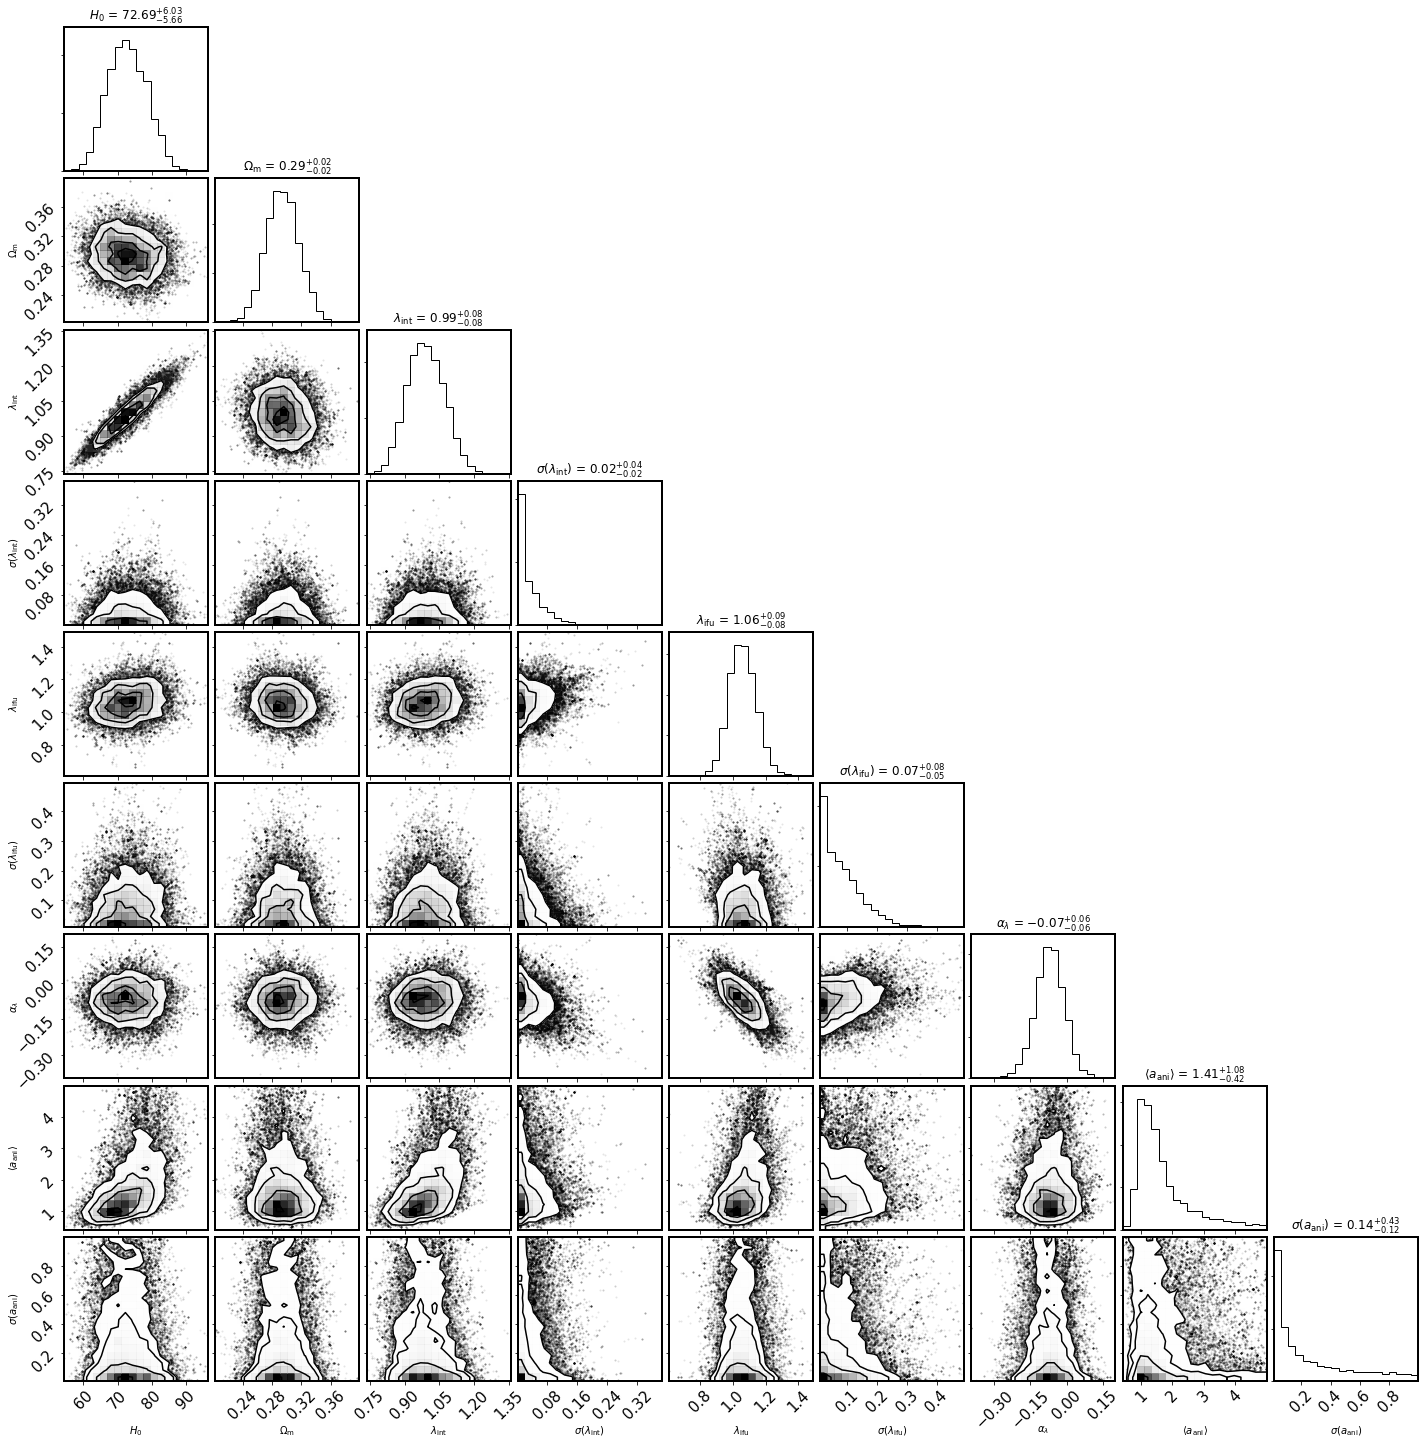

In [7]:
# and here we combine TDCOSMO and IFU

kwargs_sampler_ifu = copy.deepcopy(kwargs_sampler)
if ifu_mst_sampling_separate:  # to make sure we are not sampling the systematic velocity dispersion component when not using the SDSS measurements
    kwargs_sampler_ifu['sigma_v_systematics'] = False
if all_slacs_sample is True:
    lens_list = tdcosmo_posterior_list + kwargs_ifu_all_list
else:
    lens_list = tdcosmo_posterior_list + kwargs_ifu_quality_list

mcmc_sampler_tdcosmo_ifu = MCMCSampler(lens_list, cosmology, kwargs_bounds,
                                       lambda_ifu_sampling=ifu_mst_sampling_separate, lambda_ifu_distribution='GAUSSIAN',
                                       **kwargs_sampler_ifu)

filename = "tdcosmo_ifu_chain"+lambda_prefix+".h5"
print(filename)
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_tdcosmo_ifu, log_prob_tdcosmo_ifu = mcmc_sampler_tdcosmo_ifu.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                       kwargs_mean_start, kwargs_sigma_start, 
                                                                       continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_tdcosmo_ifu = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_tdcosmo_ifu = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

mcmc_samples_tdcosmo_ifu_plot = copy.deepcopy(mcmc_samples_tdcosmo_ifu)
print(np.shape(mcmc_samples_tdcosmo_ifu_plot))
if blinded_plot is True:
    mcmc_samples_tdcosmo_ifu_plot[:, 0] *= 73 / np.mean(mcmc_samples_tdcosmo_ifu_plot[:, 0])
    mcmc_samples_tdcosmo_ifu_plot[:, 2] *= 1 / np.mean(mcmc_samples_tdcosmo_ifu_plot[:, 2])
        
    
corner.corner(mcmc_samples_tdcosmo_ifu_plot, show_titles=True, labels=mcmc_sampler_tdcosmo_ifu.param_names(latex_style=True))
plt.show()

## TDCOSMO+SLACS SDSS sample
Here we perform the joint inference of the TDCOSMO and SLACS SDSS velocity dispersion measurements. IFU constraints are left out in this inference.


In [ ]:
if all_slacs_sample is True:
    lens_list = tdcosmo_posterior_list + kwargs_sdss_all_list
else:
    lens_list = tdcosmo_posterior_list + kwargs_sdss_quality_list

mcmc_sampler_slacs = MCMCSampler(lens_list, cosmology, kwargs_bounds, **kwargs_sampler)
ndim = mcmc_sampler_slacs.param.num_param
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tdcosmo_slacs_chain"+lambda_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_slacs, log_prob_slacs = mcmc_sampler_slacs.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                       kwargs_mean_start, kwargs_sigma_start, 
                                                                       continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_slacs = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_slacs = backend.get_log_prob(discard=n_burn, flat=True, thin=1)
mcmc_samples_slacs_plot = copy.deepcopy(mcmc_samples_slacs)
if blinded_plot is True:
    mcmc_samples_slacs_plot[:, 0] *= 73 / np.mean(mcmc_samples_slacs_plot[:, 0])
    mcmc_samples_slacs_plot[:, 2] *= 1 / np.mean(mcmc_samples_slacs_plot[:, 2])
    
corner.corner(mcmc_samples_slacs_plot, show_titles=True, labels=mcmc_sampler_slacs.param_names(latex_style=True))
plt.show()



 40%|████      | 40/100 [1:15:43<2:05:04, 125.08s/it]

## TDCOSMO+SLACS+IFU
Here we perform the joint inference of the full data set for our final result on $H_0$.

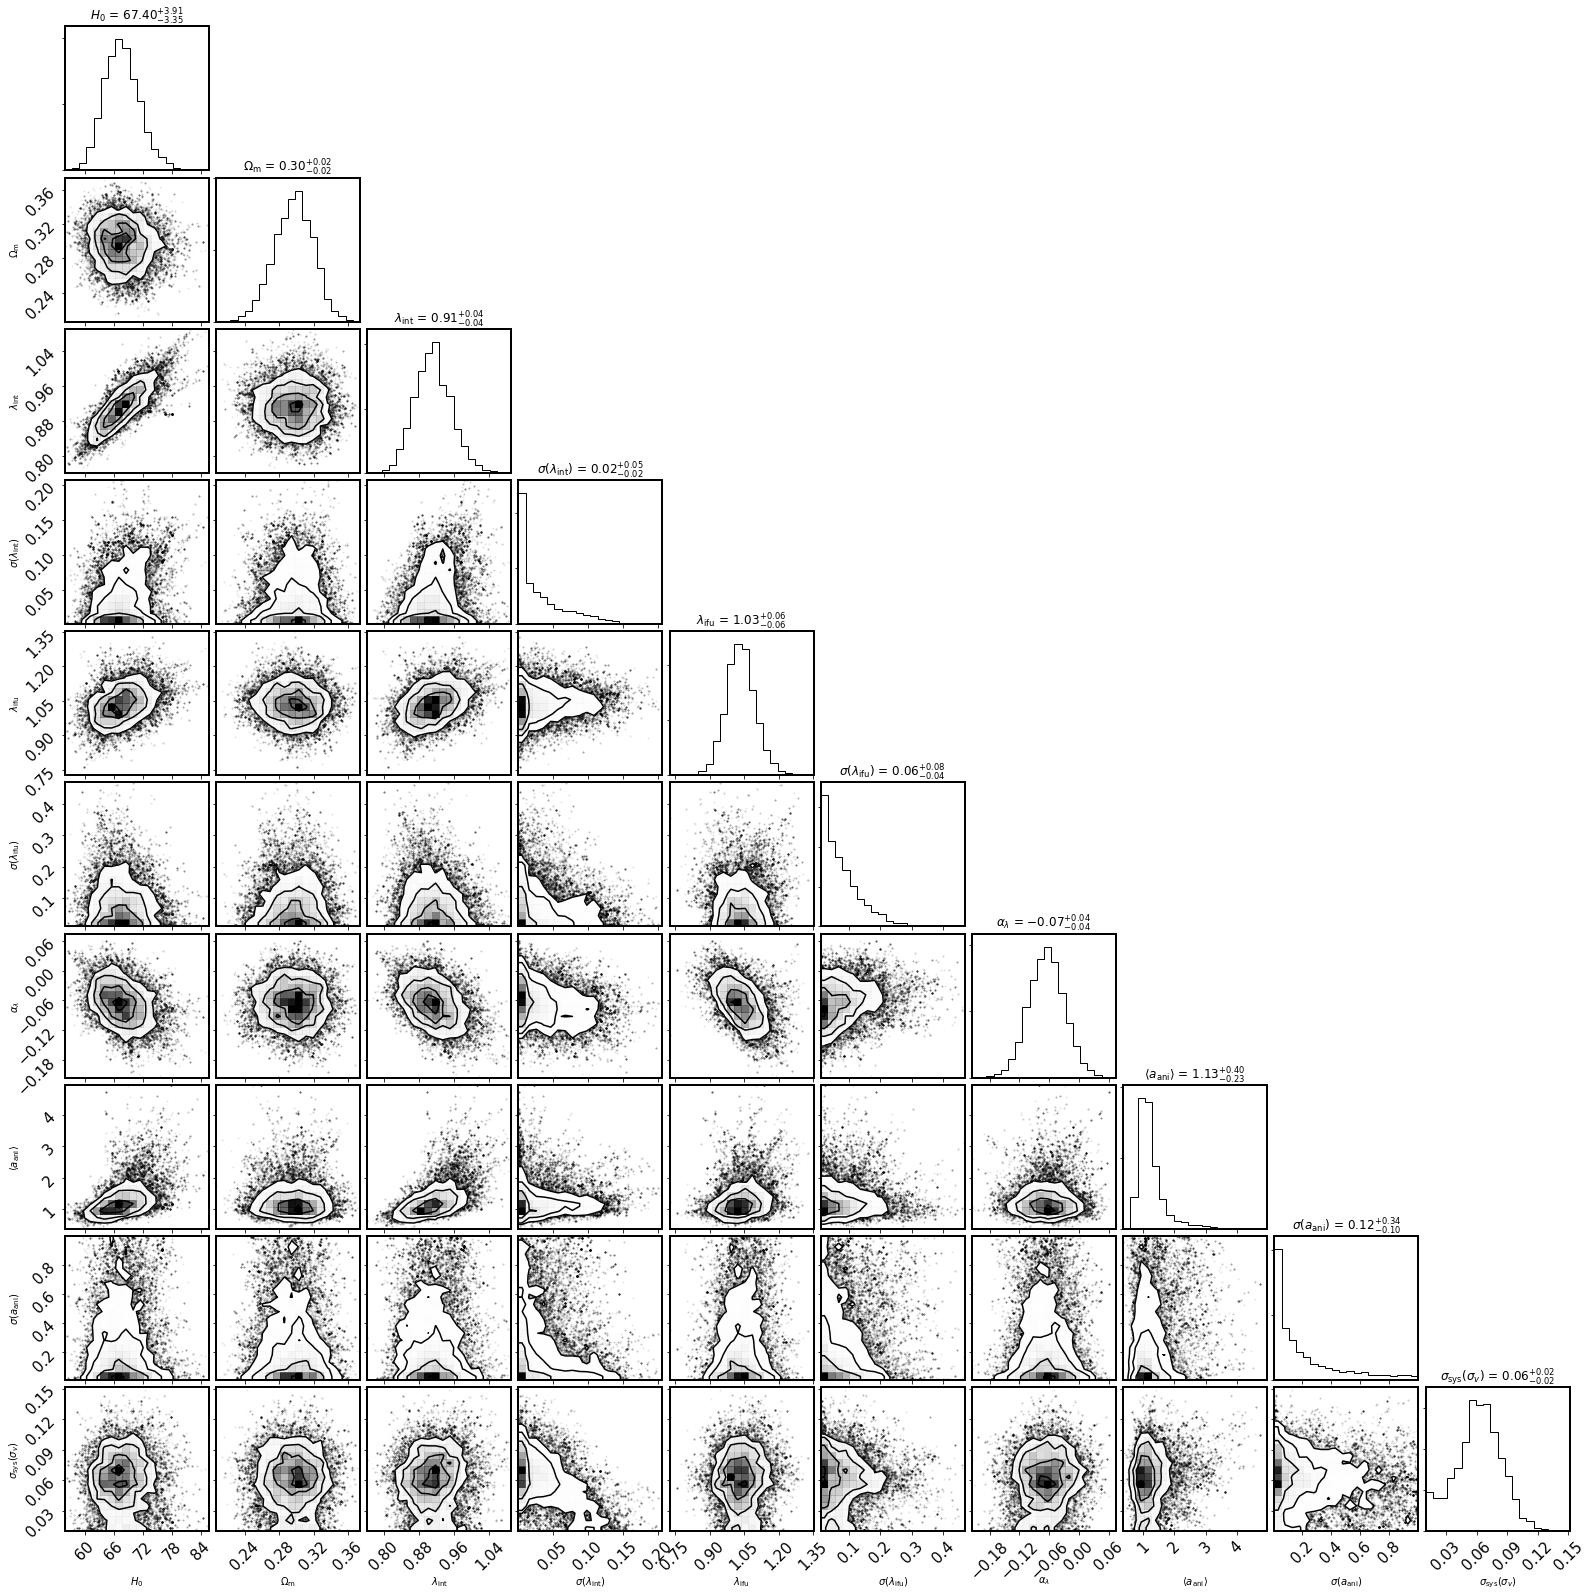

In [9]:
# and here we sample with the IFU data
if all_slacs_sample is True:
    lens_list = tdcosmo_posterior_list + kwargs_sdss_all_list + kwargs_ifu_all_list
else:
    lens_list = tdcosmo_posterior_list + kwargs_sdss_quality_list + kwargs_ifu_quality_list

mcmc_sampler_slacs_ifu = MCMCSampler(lens_list, cosmology, kwargs_bounds, 
                                     lambda_ifu_sampling=ifu_mst_sampling_separate, lambda_ifu_distribution='GAUSSIAN',
                                     **kwargs_sampler)

ndim = mcmc_sampler_slacs_ifu.param.num_param
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tdcosmo_slacs_ifu_chain"+model_prefix+lambda_prefix+".h5"
backend = emcee.backends.HDFBackend(filename)
if run_chains is True:
    mcmc_samples_slacs_ifu, log_prob_slacs_ifu = mcmc_sampler_slacs_ifu.mcmc_emcee(n_walkers, n_burn, n_run, 
                                                                               kwargs_mean_start, kwargs_sigma_start, 
                                                                               continue_from_backend=continue_from_backend, backend=backend)
else:
    mcmc_samples_slacs_ifu = backend.get_chain(discard=n_burn, flat=True, thin=1)
    log_prob_slacs_ifu = backend.get_log_prob(discard=n_burn, flat=True, thin=1)

mcmc_samples_slacs_ifu_plot = copy.deepcopy(mcmc_samples_slacs_ifu)
if blinded_plot is True:
    mcmc_samples_slacs_ifu_plot[:, 0] *= 73 / np.mean(mcmc_samples_slacs_ifu_plot[:, 0])
    mcmc_samples_slacs_ifu_plot[:, 2] *= 1 / np.mean(mcmc_samples_slacs_ifu_plot[:, 2])

corner.corner(mcmc_samples_slacs_ifu_plot, show_titles=True, labels=mcmc_sampler_slacs_ifu.param_names(latex_style=True))
plt.show()



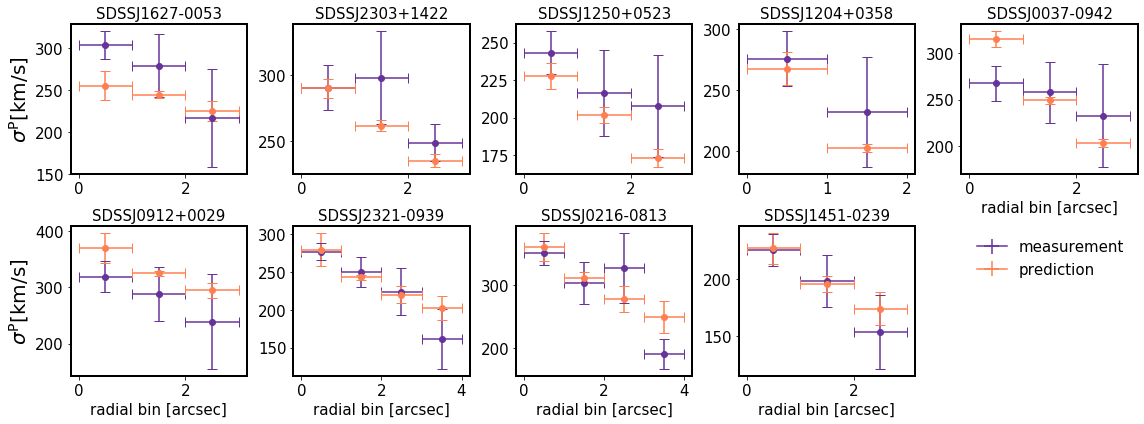

-151.78765200549043 log likelihood


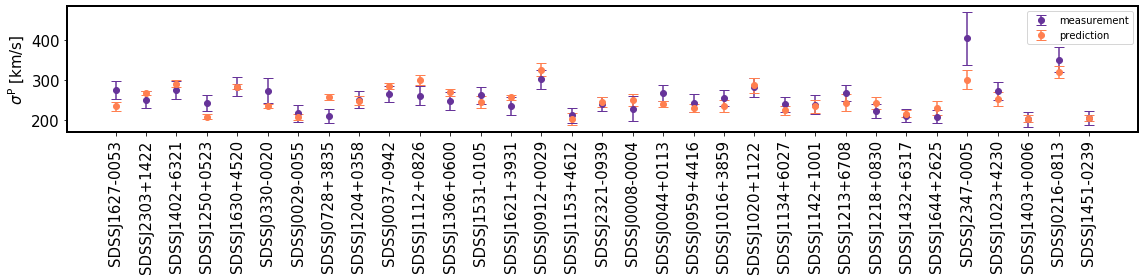

-65.46647416933345 log likelihood


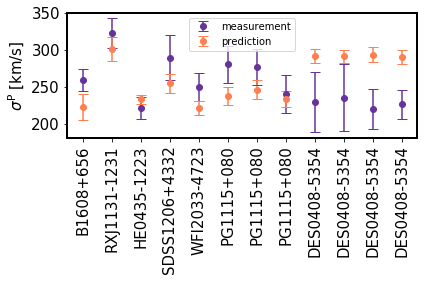

-65.55536654324817 log likelihood
6.900564899289281 reduced chi2


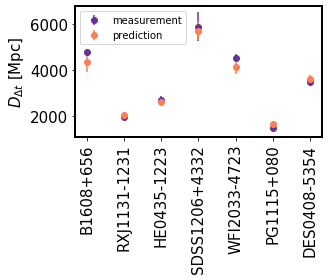

In [10]:
# get best fit
color_measurement = 'rebeccapurple'  # 'tab:blue'
color_prediction = 'coral' #'tab:orange'

index_best_fit = np.where(log_prob_slacs_ifu == np.max(log_prob_slacs_ifu))

kwargs_cosmo_best_fit, kwargs_lens_best_fit, kwargs_kin_best_fit = mcmc_sampler_slacs_ifu.param.args2kwargs(mcmc_samples_slacs_ifu[index_best_fit[0][0]])
cosmo_best_fit = mcmc_sampler_slacs_ifu.param.cosmo(kwargs_cosmo_best_fit)

fit = GoodnessOfFit(kwargs_ifu_all_list)
num_lenses = len(kwargs_ifu_all_list)
f, axes = plt.subplots(2, int(num_lenses/2.+0.5), figsize=(4*int(num_lenses/2.), 6))
ax_1, ax_2 = 0, 0
for lens_index, kwargs_ifu in enumerate(kwargs_ifu_all_list):
    name = kwargs_ifu['name']
    ax = fit.plot_ifu_fit(ax=axes[ax_1, ax_2], cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit,
             kwargs_kin=kwargs_kin_best_fit, lens_index=lens_index, show_legend=False, radial_bin_size=1, 
                          color_measurement=color_measurement, color_prediction=color_prediction)
    ax.set_title(name, fontsize=15)
    ax.set_ylabel(r'', fontsize=20)
    ax.set_xlabel('', fontsize=20)
    if ax_1 == 1:
        ax.set_xlabel('radial bin [arcsec]', fontsize=15)
    if ax_2 == 0:
        ax.set_ylabel(r'$\sigma^{\rm P}$[km/s]', fontsize=20)
    
    ax_2 += 1
    if ax_2 == int(num_lenses/2.+0.5):
        ax_1 +=1
        ax_2 = 0
while lens_index < len(axes) * len(axes[0]) - 1:
    ax=axes[ax_1, ax_2]
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax_2 += 1
    lens_index += 1
axes[0, 4].set_xlabel('radial bin [arcsec]', fontsize=15)
ax = axes[1, 4]
ax.errorbar([1], [1], yerr=[1], xerr=[1], label='measurement', color=color_measurement)
ax.errorbar([1], [1], yerr=[1], xerr=[1], label='prediction', color=color_prediction)
ax.set_xlim([-10, -9])
ax.legend(fontsize=15, frameon=False)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/ifu_best_fit.pdf')
plt.show()


fit = GoodnessOfFit(kwargs_sdss_all_list)
fig, axes = fit.plot_kin_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit, kwargs_kin=kwargs_kin_best_fit, color_measurement=color_measurement, color_prediction=color_prediction)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/sdss_best_fit.pdf')
plt.show()


fit = GoodnessOfFit(tdcosmo_posterior_list)
fig, axes = fit.plot_kin_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit, kwargs_kin=kwargs_kin_best_fit, color_measurement=color_measurement, color_prediction=color_prediction)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/tdcosmo_sigma_v_best_fit.pdf')
plt.show()


fig, axes = fit.plot_ddt_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit, kwargs_kin=kwargs_kin_best_fit, color_measurement=color_measurement, color_prediction=color_prediction)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/ddt_best_fit.pdf')
plt.show()


In [11]:
NoverRmed_random = 1.028768  # N/r value from 100000 random patches on the sky with same survey and depth as the lenses

def NoverRmed(name):
    """
    reads out the number for N/r weigthing from the DECals data in the table for a specific lens
    """
    with open(file_name_slacs_los, newline='') as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            if '#name' in row:
                name_row = row['#name']
                if name_row == name:
                    return float(row['NoverRmed']) / NoverRmed_random
    print('lens with name %s not in table.' % (name))
    return -1



# SLACS sample
fit = GoodnessOfFit(kwargs_sdss_all_list)
name_list, sigma_v_measurement_list, sigma_v_measurement_error_list, sigma_v_model_list, sigma_v_model_error_list = fit.kin_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit, kwargs_kin=kwargs_kin_best_fit)
sigma_v_measurement_list = np.array(sigma_v_measurement_list)
sigma_v_model_list = np.array(sigma_v_model_list)
sigma_v_measurement_error_list = np.array(sigma_v_measurement_error_list)
sigma_v_model_error_list = np.array(sigma_v_model_error_list)

def kappa_uncertainties(name):
    filepath = os.path.join(path2kappa, 'kappahist_'+name+kappa_choice_ending)
    output = np.loadtxt(filepath, delimiter=' ', skiprows=1)
    kappa_samples = output[:, 0]
    kappa_weights = output[:, 1]
    kappa_pdf, kappa_bin_edges = np.histogram(kappa_sample, weights=kappa_weights, bins=kappa_bins, density=True)
    pdf_tot = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf)
    kappa_samples = pdf_tot.draw(n=100000)
    pcs = np.percentile(kappa_samples, q=percentiles)
    return pcs


def kappa_uncertainties_tdcosmo(name):
    for posterior in tdcosmo_posterior_list:
        if posterior['name'] == name:
            kappa_pdf = posterior['kappa_pdf']
            kappa_bin_edges = posterior['kappa_bin_edges']
            pdf_tot = PDFSampling(bin_edges=kappa_bin_edges, pdf_array=kappa_pdf)
            kappa_samples = pdf_tot.draw(n=100000)
            pcs = np.percentile(kappa_samples, q=percentiles)
            return pcs
            

zeta_r_list, theta_E_list, r_eff_list, gamma_pl_list, z_lens_list, z_source_list, sigma_sis_list, kappa_pcs_list = [], [], [], [], [], [], [], []

for name in name_list:
    zeta_r = NoverRmed(name)
    theta_E, r_eff, gamma_pl, z_lens, z_source, sigma_sis = properties(name, file_name_slacs)
    zeta_r_list.append(zeta_r)
    theta_E_list.append(theta_E)
    r_eff_list.append(r_eff)
    gamma_pl_list.append(gamma_pl)
    z_lens_list.append(z_lens)
    z_source_list.append(z_source)
    sigma_sis_list.append(sigma_sis)
    pcs = kappa_uncertainties(name)
    kappa_pcs_list.append(pcs)

theta_E_list = np.array(theta_E_list)
r_eff_list = np.array(r_eff_list)
zeta_r_list = np.array(zeta_r_list)

delta_sigma = (sigma_v_measurement_list - sigma_v_model_list) / sigma_v_measurement_list
delta_sigma_error = np.sqrt(sigma_v_measurement_error_list**2 + sigma_v_model_error_list**2) / sigma_v_measurement_list


#TDCOSMO sample

fit_tdcosmo = GoodnessOfFit(tdcosmo_posterior_list)
name_list_tdcosmo, sigma_v_measurement_list_tdcosmo, sigma_v_measurement_error_list_tdcosmo, sigma_v_model_list_tdcosmo, sigma_v_model_error_list_tdcosmo = fit_tdcosmo.kin_fit(cosmo=cosmo_best_fit, kwargs_lens=kwargs_lens_best_fit, kwargs_kin=kwargs_kin_best_fit)
sigma_v_measurement_list_tdcosmo = np.array(sigma_v_measurement_list_tdcosmo)
sigma_v_model_list_tdcosmo = np.array(sigma_v_model_list_tdcosmo)
sigma_v_measurement_error_list_tdcosmo = np.array(sigma_v_measurement_error_list_tdcosmo)
sigma_v_model_error_list_tdcosmo = np.array(sigma_v_model_error_list_tdcosmo)


theta_E_list_tdcosmo, r_eff_list_tdcosmo, gamma_pl_list_tdcosmo, z_lens_list_tdcosmo, z_source_list_tdcosmo, sigma_sis_list_tdcosmo, kappa_pcs_list_tdcosmo = [], [], [], [], [], [], []

for name in name_list_tdcosmo:
    theta_E, r_eff, gamma_pl, z_lens, z_source, sigma_sis = properties(name, file_name_tdcosmo, partial_name=True)
    theta_E_list_tdcosmo.append(theta_E)
    r_eff_list_tdcosmo.append(r_eff)
    gamma_pl_list_tdcosmo.append(gamma_pl)
    z_lens_list_tdcosmo.append(z_lens)
    z_source_list_tdcosmo.append(z_source)
    sigma_sis_list_tdcosmo.append(sigma_sis)
    pcs = kappa_uncertainties_tdcosmo(name)
    kappa_pcs_list_tdcosmo.append(pcs)

theta_E_list_tdcosmo = np.array(theta_E_list_tdcosmo)
r_eff_list_tdcosmo = np.array(r_eff_list_tdcosmo)

kappa_mean_list_slacs = []
kappa_lower_list_slacs = []
kappa_upper_list_slacs = []
for pcs in kappa_pcs_list:
    kappa_mean_list_slacs.append(pcs[1])
    kappa_lower_list_slacs.append(pcs[1] - pcs[0])
    kappa_upper_list_slacs.append(pcs[2] - pcs[1])

kappa_mean_list_tdcosmo = []
kappa_lower_list_tdcosmo = []
kappa_upper_list_tdcosmo = []
for pcs in kappa_pcs_list_tdcosmo:
    kappa_mean_list_tdcosmo.append(pcs[1])
    kappa_lower_list_tdcosmo.append(pcs[1] - pcs[0])
    kappa_upper_list_tdcosmo.append(pcs[2] - pcs[1])



delta_sigma_tdcosmo = (sigma_v_measurement_list_tdcosmo - sigma_v_model_list_tdcosmo) / sigma_v_measurement_list_tdcosmo
delta_sigma_error_tdcosmo = np.sqrt(sigma_v_measurement_error_list_tdcosmo**2 + sigma_v_model_error_list_tdcosmo**2) / sigma_v_measurement_list_tdcosmo


def plot_trend(ax, variable, delta_sigma, delta_sigma_error, variable_name=None, color=None):
    
    
    ax.errorbar(variable, delta_sigma,
                         yerr=delta_sigma_error, xerr=None, fmt='o',
                         ecolor=None, elinewidth=None,
                         capsize=5, barsabove=False, lolims=False, uplims=False,
                         xlolims=False, xuplims=False, errorevery=1, capthick=None, data=None, label=None, color=color)
    ax.axhline(y=0, linestyle='--', color='k')
    #ax.errorbar(variable, sigma_v_model_list,
    #                     yerr=sigma_v_model_error_list, xerr=None, fmt='o',
    #                     ecolor=None, elinewidth=None, label='prediction', capsize=5)
    #ax.plot(variable, (sigma_v_measurement_list - sigma_v_model_list) / sigma_v_measurement_list, 'o')
    ax.set_xlabel(variable_name, fontsize=20)
    
    return ax





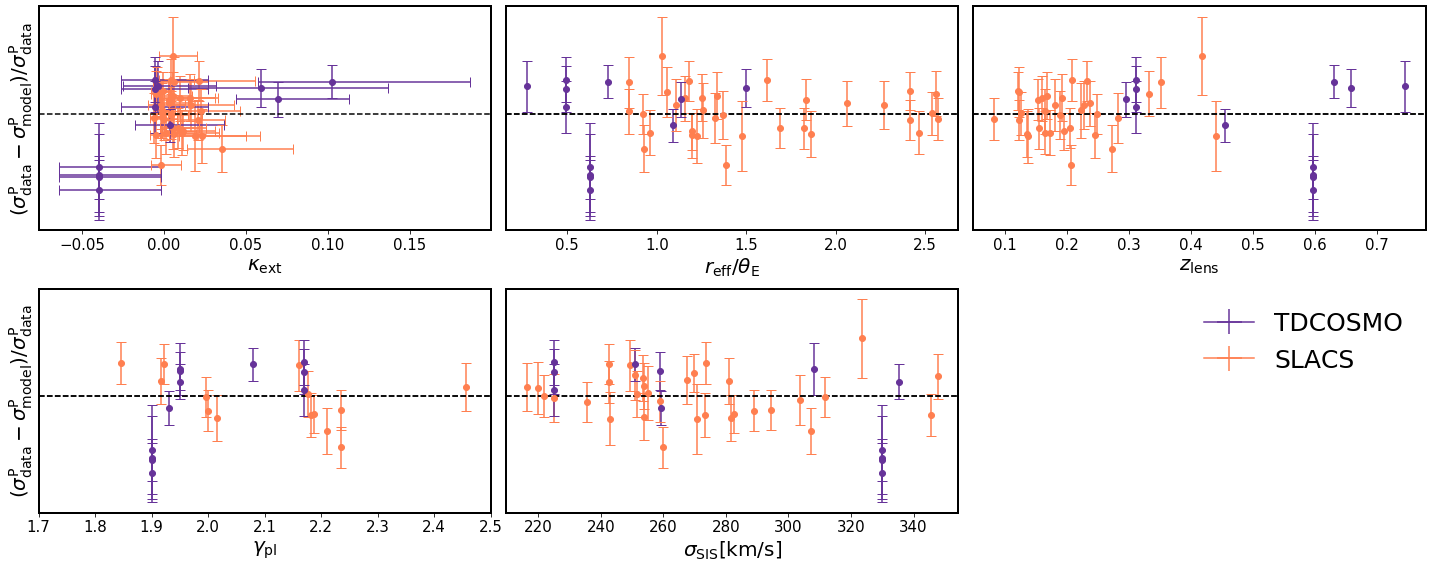

In [12]:
#cmap_list=["Blues", "Reds", "Greens", "Purples", "Oranges", "Reds", "BuPu", "Greys"]
color_list = ['royalblue', 'coral', 'rebeccapurple', 'crimson', 'g', 'purple', 'orange', 'r', 'k']
alpha = 0.8
#levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 1.1, 0.5) ** 2)
levels = [0.68,0.95]

tdcosmo_color = color_list[2] # 'b'
slacs_color = color_list[1] # 'r'

f, axes = plt.subplots(2, 3, figsize=(20, 8), sharey=True)
#ax = plot_trend(axes[0, 0], zeta_r_list, delta_sigma, delta_sigma_error, r'$\zeta_{1/r}$')
ax = plot_trend(axes[0, 1], r_eff_list/theta_E_list, delta_sigma, delta_sigma_error, r'$r_{\rm eff}/\theta_{\rm E}$', color=slacs_color)
ax = plot_trend(axes[0, 1], r_eff_list_tdcosmo/theta_E_list_tdcosmo, delta_sigma_tdcosmo, delta_sigma_error_tdcosmo, r'$r_{\rm eff}/\theta_{\rm E}$', color=tdcosmo_color)

ax = plot_trend(axes[0, 2], z_lens_list, delta_sigma, delta_sigma_error, r'$z_{\rm lens}$', color=slacs_color)
ax = plot_trend(axes[0, 2], z_lens_list_tdcosmo, delta_sigma_tdcosmo, delta_sigma_error_tdcosmo, r'$z_{\rm lens}$', color=tdcosmo_color)
ax = plot_trend(axes[1, 0], gamma_pl_list, delta_sigma, delta_sigma_error, r'$\gamma_{\rm pl}$', color=slacs_color)
ax = plot_trend(axes[1, 0], gamma_pl_list_tdcosmo, delta_sigma_tdcosmo, delta_sigma_error_tdcosmo, r'$\gamma_{\rm pl}$', color=tdcosmo_color)
ax.set_xlim([1.7, 2.5])
ax = plot_trend(axes[1, 1], sigma_sis_list, delta_sigma, delta_sigma_error, r'$\sigma_{\rm SIS}$[km/s]', color=slacs_color)
ax = plot_trend(axes[1, 1], sigma_sis_list_tdcosmo, delta_sigma_tdcosmo, delta_sigma_error_tdcosmo, r'$\sigma_{\rm SIS}$[km/s]', color=tdcosmo_color)


#ax = plot_trend(axes[2], theta_E_list/r_eff_list, delta_sigma, delta_sigma_error, r'$\theta_{\rm E}/ r_{\rm eff}$')
#ax = plot_trend(axes[2], theta_E_list_tdcosmo/r_eff_list_tdcosmo, delta_sigma_tdcosmo, delta_sigma_error_tdcosmo, r'$\theta_{\rm E}/ r_{\rm eff}$')

axes[0, 0].set_ylabel(r'$(\sigma^{\rm P}_{\rm data} - \sigma^{\rm P}_{\rm model})/ \sigma^{\rm P}_{\rm data}$', fontsize=20)

axes[1, 0].set_ylabel(r'$(\sigma^{\rm P}_{\rm data} - \sigma^{\rm P}_{\rm model})/ \sigma^{\rm P}_{\rm data}$', fontsize=20)

ax = axes[0, 0]
ax.errorbar(kappa_mean_list_slacs, delta_sigma,
    yerr=delta_sigma_error, xerr=[kappa_lower_list_slacs, kappa_upper_list_slacs], fmt='o',
                         ecolor=None, elinewidth=None, color=slacs_color,
                         capsize=5, barsabove=False, lolims=False, uplims=False,
                         xlolims=False, xuplims=False, errorevery=1, capthick=None, data=None, label=None)
ax.errorbar(kappa_mean_list_tdcosmo, delta_sigma_tdcosmo,
    yerr=delta_sigma_error_tdcosmo, xerr=[kappa_lower_list_tdcosmo, kappa_upper_list_tdcosmo], fmt='o',
                         ecolor=None, elinewidth=None, color=tdcosmo_color,
                         capsize=5, barsabove=False, lolims=False, uplims=False,
                         xlolims=False, xuplims=False, errorevery=1, capthick=None, data=None, label=None)

ax.axhline(y=0, linestyle='--', color='k')
ax.set_xlabel(r'$\kappa_{\rm ext}$', fontsize=20)

# legend with empty space
ax = axes[1, 2]
ax.errorbar([0], [0], yerr=[0.1], xerr=[0.1], label='TDCOSMO', color=tdcosmo_color)
ax.errorbar([0], [0], yerr=[0.1], xerr=[0.1], label='SLACS', color=slacs_color)
ax.set_xlim([-10, -9])
#ax.plot([], [], label='TDCOSMO', color=tdcosmo_color)
#ax.plot([], [], label='SLACS', color=slacs_color)

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=25, frameon=False)

plt.tight_layout()
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/kin_fit_trends.pdf')

plt.show()



In [13]:
# read in TDCOSMO-only sample with free alpha_lambda and tight omega_m prior
#filename = os.path.join(path2Analysis, path2tdcosmo, 'tdcosmo_chain_alpha_free.h5')
n_burn_tdcosmo = 0

filename = os.path.join(path2Analysis, path2tdcosmo, 'tdcosmo_chain_alpha_free_om.h5')
backend = emcee.backends.HDFBackend(filename)
mcmc_samples_tdcosmo = backend.get_chain(discard=n_burn_tdcosmo, flat=True, thin=1)
log_prob_tdcosmo = backend.get_log_prob(discard=n_burn_tdcosmo, flat=True, thin=1)

filename = os.path.join(path2Analysis, path2tdcosmo, 'tdcosmo_chain_alpha_fixed_om.h5')
backend = emcee.backends.HDFBackend(filename)
mcmc_samples_tdcosmo_fixed_alpha = backend.get_chain(discard=n_burn_tdcosmo, flat=True, thin=1)
log_prob_tdcosmo_fixed_alpha = backend.get_log_prob(discard=n_burn_tdcosmo, flat=True, thin=1)

In [14]:

def select_params(mcmc_samples, param_names, param_names_select, blinded_plot=False):
    """
    selects a subset of the parameters to be plotted
    """
    
    keep_list = []
    for i, param_name in enumerate(param_names):
        if param_name in param_names_select:
            keep_list.append(i)
    mcmc_samples_select = copy.deepcopy(mcmc_samples.T[keep_list].T)
    if blinded_plot is True:
        mcmc_samples_select[:, 0] *= 73 / np.median(mcmc_samples_select[:, 0])
        #mcmc_samples_select[:, 0] -= 73
        mcmc_samples_select[:, 2] *= 1 / np.median(mcmc_samples_select[:, 2])
    return mcmc_samples_select

if lambda_slope is True:
    param_names_select = ['h0', 'om', 'lambda_mst', 'lambda_mst_sigma', 'alpha_lambda', 'a_ani', 'a_ani_sigma']
    extents = [[50, 100], [0.15, 0.4], [0.7, 1.3], [0, 0.25], [-0.2, 0.2], [0.1, 5], [0, 1]]
else:
    param_names_select = ['h0', 'om', 'lambda_mst', 'lambda_mst_sigma',  'a_ani', 'a_ani_sigma']
    extents = [[50, 100], [0.15, 0.4], [0.7, 1.3], [0, 0.25], [0.1, 5], [0, 1]]

#if blinded_plot is True:
#    extents[0] = [-20, 20]
if lambda_slope is True:
    labels = [r'$H_0$', r'$\Omega_{\rm m}$', r'$\lambda_{\rm int,0}$', r'$\sigma(\lambda_{\rm int})$', r'$\alpha_{\lambda}$', r'$\langle a_{\rm ani}\rangle$', r'$\sigma(a_{\rm ani})$']
else:
    labels = [r'$H_0$', r'$\Omega_{\rm m}$', r'$\lambda_{\rm int,0}$', r'$\sigma(\lambda_{\rm int})$', r'$\langle a_{\rm ani}\rangle$', r'$\sigma(a_{\rm ani})$']



mcmc_samples_tdcosmo_select = select_params(mcmc_samples_tdcosmo, mcmc_sampler_tdcosmo.param_names(latex_style=False), param_names_select, blinded_plot=blinded_plot)
mcmc_samples_slacs_select = select_params(mcmc_samples_slacs, mcmc_sampler_slacs.param_names(latex_style=False), param_names_select, blinded_plot=blinded_plot)
mcmc_samples_slacs_ifu_select = select_params(mcmc_samples_slacs_ifu, mcmc_sampler_slacs_ifu.param_names(latex_style=False), param_names_select, blinded_plot=blinded_plot)



(185000, 7)


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


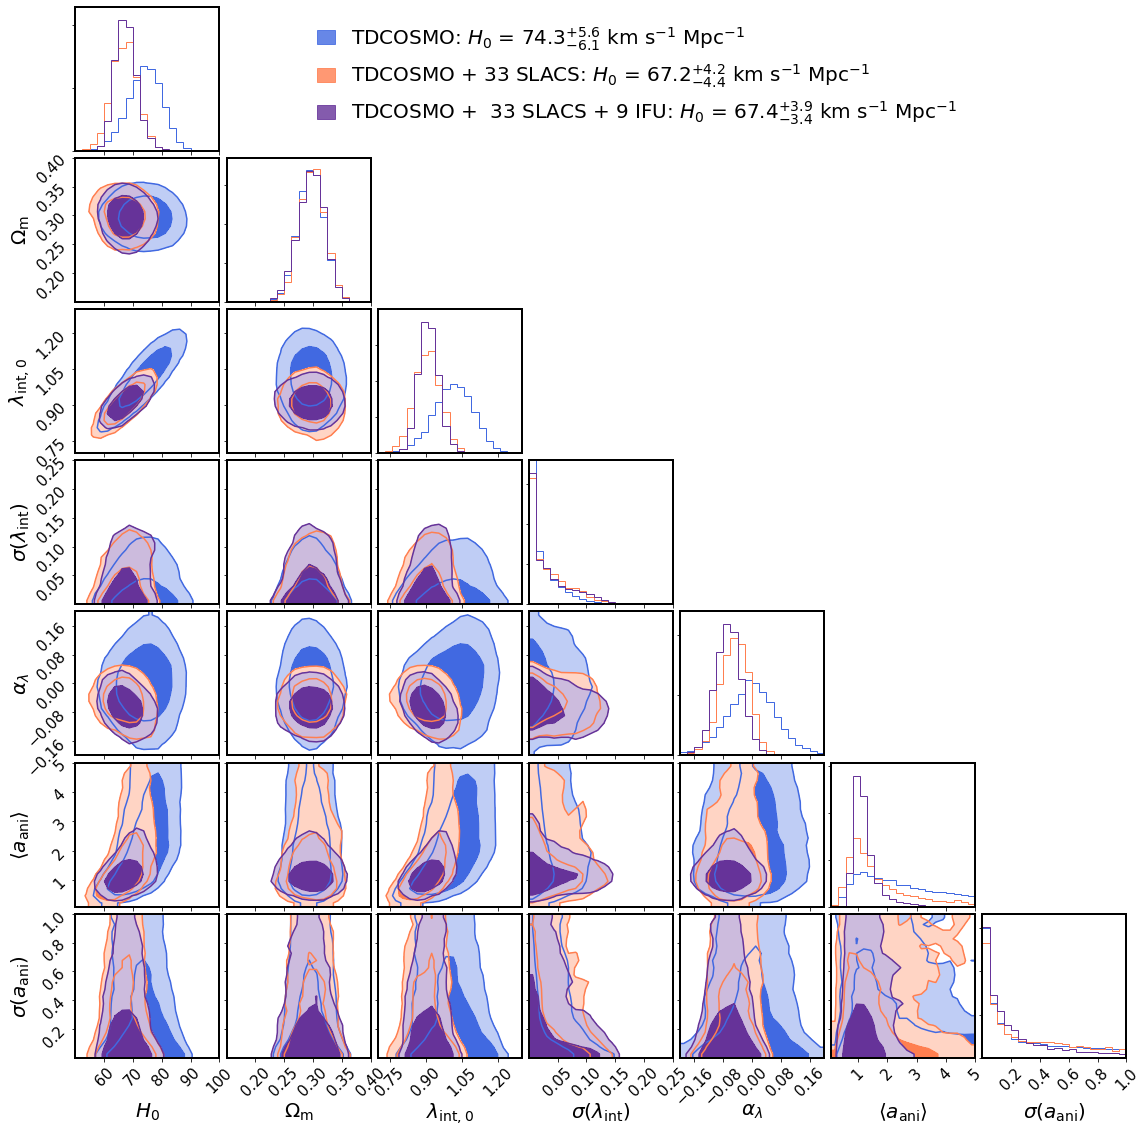

In [15]:
#'rebeccapurple'
#'coral'

kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.7, 'smooth1d': None, 
                 'levels': levels, 
                 'fill_contours': True, 'plot_datapoints': False,
                 'range': extents}
print(np.shape(mcmc_samples_tdcosmo_select))
fig = corner.corner(mcmc_samples_tdcosmo_select,
                    labels=labels,
                    color=color_list[0],
                    hist_kwargs= {'density': True, 'color': color_list[0]},
                    title_kwargs=dict(fontsize=15),
                    label_kwargs=dict(fontsize=20),
                    **kwargs_corner
                   )
fig = corner.corner(mcmc_samples_slacs_select, color=color_list[1], fig=fig,
                    hist_kwargs= {'density': True, 'color': color_list[1]}, **kwargs_corner)
fig = corner.corner(mcmc_samples_slacs_ifu_select, color=color_list[2], fig=fig, 
                    hist_kwargs= {'density': True, 'color': color_list[2]},
                    labels=labels, show_titles=False, **kwargs_corner)


ax = fig.axes[5]
ax.set_visible(True)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
result_string_cosmo = plot_util.result_string(mcmc_samples_tdcosmo_select[:,0], weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_combined = plot_util.result_string(mcmc_samples_slacs_select[:,0], weights=None, title_fmt=".1f", label=r'$H_0$')
result_string_ifu = plot_util.result_string(mcmc_samples_slacs_ifu_select[:,0], weights=None, title_fmt=".1f", label=r'$H_0$')


patch_1 = mpatches.Patch(color=color_list[0], label='TDCOSMO: ' + result_string_cosmo +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_2 = mpatches.Patch(color=color_list[1], label='TDCOSMO + ' + str(num_slacs) + ' SLACS: ' + result_string_combined +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)
patch_3 = mpatches.Patch(color=color_list[2], label='TDCOSMO +  ' + str(num_slacs) + ' SLACS + ' + str(num_ifu) + ' IFU: ' + result_string_ifu +r' km s$^{-1}$ Mpc$^{-1}$', alpha=alpha)


ax.legend(handles=[patch_1, patch_2, patch_3], fontsize=20, handlelength=0.9, loc=1, frameon=False)
#plt.savefig('/Users/sibirrer/Science/Projects/TDCOSMO/hierarchy_paper/Figures/result_joint.pdf')
fig.show()


In [16]:
# print table
# H0, lambda_int, alpha_lambda, sigma(lambda_int), a_ani, sigma(a_ani), sigma(sigmaP)
if blinded_plot is False:
    # fixed alpha for TDCOSMO only
    print('TDCOSMO-only ($ alpha_{ \lambda}=0)$', '&',
          plot_util.result_string(mcmc_samples_tdcosmo_fixed_alpha[:,0], title_fmt=".1f"), '&', 
          plot_util.result_string(mcmc_samples_tdcosmo_fixed_alpha[:,2], title_fmt=".2f"), '&',
          '=0', '&',
          plot_util.result_string(mcmc_samples_tdcosmo_fixed_alpha[:,3], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo_fixed_alpha[:,4], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo_fixed_alpha[:,5], title_fmt=".2f"), '&',
          '-', ' \\\ ', )
    # free alpha for TDCOSMO only
    print('TDCOSMO-only', '&',
          plot_util.result_string(mcmc_samples_tdcosmo[:,0], title_fmt=".1f"), '&', 
          plot_util.result_string(mcmc_samples_tdcosmo[:,2], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo[:,4], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo[:,3], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo[:,5], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo[:,6], title_fmt=".2f"), '&',
          '-', ' \\\ ', )

    # TDCOSMO + IFU
    print('TDCOSMO + IFU', '&',
          plot_util.result_string(mcmc_samples_tdcosmo_ifu[:,0], title_fmt=".1f"), '&', 
          plot_util.result_string(mcmc_samples_tdcosmo_ifu[:,2], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo_ifu[:,6], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo_ifu[:,5], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo_ifu[:,7], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_tdcosmo_ifu[:,8], title_fmt=".2f"), '&',
          '-', ' \\\ ', )

    # TDCOSMO + SLACS
    print('TDCOSMO + SLACS', '&',
          plot_util.result_string(mcmc_samples_slacs[:,0], title_fmt=".1f"), '&', 
          plot_util.result_string(mcmc_samples_slacs[:,2], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs[:,4], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs[:,3], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs[:,5], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs[:,6], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs[:,7], title_fmt=".2f"), ' \\\ ', )

    # TDCOSMO + SLACS + IFU
    print('TDCOSMO + SLACS + IFU', '&',
          plot_util.result_string(mcmc_samples_slacs_ifu[:,0], title_fmt=".1f"), '&', 
          plot_util.result_string(mcmc_samples_slacs_ifu[:,2], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs_ifu[:,6], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs_ifu[:,5], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs_ifu[:,7], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs_ifu[:,8], title_fmt=".2f"), '&',
          plot_util.result_string(mcmc_samples_slacs_ifu[:,9], title_fmt=".2f"), ' \\\ ', )

TDCOSMO-only ($ alpha_{ \lambda}=0)$ & ${73.6}_{-6.2}^{+5.8}$ & ${1.00}_{-0.08}^{+0.08}$ & =0 & ${0.01}_{-0.01}^{+0.03}$ & ${2.07}_{-1.07}^{+1.71}$ & ${0.18}_{-0.15}^{+0.53}$ & -  \\ 
TDCOSMO-only & ${74.3}_{-6.1}^{+5.6}$ & ${1.02}_{-0.09}^{+0.08}$ & ${-0.00}_{-0.07}^{+0.07}$ & ${0.01}_{-0.01}^{+0.04}$ & ${2.12}_{-1.07}^{+1.67}$ & ${0.15}_{-0.12}^{+0.49}$ & -  \\ 
TDCOSMO + IFU & ${72.7}_{-5.7}^{+6.0}$ & ${0.99}_{-0.08}^{+0.08}$ & ${-0.07}_{-0.06}^{+0.06}$ & ${0.07}_{-0.05}^{+0.08}$ & ${1.41}_{-0.42}^{+1.08}$ & ${0.14}_{-0.12}^{+0.43}$ & -  \\ 
TDCOSMO + SLACS & ${67.2}_{-4.4}^{+4.2}$ & ${0.91}_{-0.05}^{+0.05}$ & ${-0.05}_{-0.04}^{+0.04}$ & ${0.02}_{-0.02}^{+0.05}$ & ${1.31}_{-0.51}^{+1.38}$ & ${0.18}_{-0.15}^{+0.46}$ & ${0.06}_{-0.03}^{+0.02}$  \\ 
TDCOSMO + SLACS + IFU & ${67.4}_{-3.4}^{+3.9}$ & ${0.91}_{-0.04}^{+0.04}$ & ${-0.07}_{-0.04}^{+0.04}$ & ${0.06}_{-0.04}^{+0.08}$ & ${1.13}_{-0.23}^{+0.40}$ & ${0.12}_{-0.10}^{+0.34}$ & ${0.06}_{-0.02}^{+0.02}$  \\ 
